# Experiment 2 with natural and artificial voice of men and women

## Loading the packages

In [1]:
# maths and graphics
import numpy as np
import matplotlib.pyplot as pl
import sys
from ipywidgets import interact, widgets

# mfcc modules
import os
import scipy.io.wavfile as wav

%matplotlib inline

# python speech
!pip install python_speech_features
from python_speech_features import mfcc

## Dataset

### Path and naming

In [2]:
PATH = 'voice_recognition/vowels/'
MALE_NATURAL_VOICE = "nam"
MALE_SYNTHESIZED_VOICE = "sam"
FEMALE_NATURAL_VOICE = "naf"
FEMALE_SYNTHESIZED_VOICE = "saf"
KID_NATURAL_VOICE = "nk"
KID_SYNTHESIZED_VOICE = "sk"

### Get files

In [3]:
def get_files(voice_type):
    files = []
    for filename in os.listdir(PATH):
        if(filename.startswith(voice_type)):
            files.append(os.path.join(PATH, filename))
    return files

### Create data from selected voice type

In [4]:
# Define datas output
men_output = 1
women_output = -1

# Initialize dataset
dataset = []

In [5]:
def add_data_from_voice_type(voice_type, class_value):
    for file in get_files(voice_type):
        sample_rate, X = wav.read(file)
        ceps = mfcc(X, samplerate=sample_rate, nfft=1024)
        
        #ceps_std = np.std(ceps, axis=0)
        ceps_mean = np.mean(ceps, axis=0)
        
        # add mean and class
        row = np.append(ceps_mean, class_value)
        
        dataset.append(row)

### Add data for experiment

In [6]:
add_data_from_voice_type(MALE_NATURAL_VOICE, men_output)
add_data_from_voice_type(MALE_SYNTHESIZED_VOICE, men_output)
add_data_from_voice_type(FEMALE_NATURAL_VOICE, women_output)
add_data_from_voice_type(FEMALE_SYNTHESIZED_VOICE, women_output)

dataset = np.array(dataset)

print(dataset.shape)
print(dataset[:,13])

(144, 14)
[ 1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.
  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.
  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.
  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.
 -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1.
 -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1.
 -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1.
 -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1.]


## Testing neural network parameters

### Imports

In [7]:
# Import the code of the backpropagation with momentum algorithm
import mlp_backprop_momentum as mlp

# Import the code of the cross-valdidation test
import k_fold_cross_validation as cv

### Exploring the number of epochs

#### Parameters

In [28]:
N_INITS = 10
EPOCHS = 300
N_NEURONS = [2, 4, 8, 16, 32]
LEARNING_RATE = 0.001
MOMENTUM = 0.5

#### Training

In [29]:
MSE = np.zeros((len(N_NEURONS), N_INITS, EPOCHS))

for i_h, h in enumerate(N_NEURONS):                                     # looping over the number of hidden neurons
    print('Testing', h, 'neurons...')
    nn = mlp.MLP([13,h,1], 'tanh')
    for i in np.arange(N_INITS):                                        # looping over the initializations
        nn.init_weights()
        
        MSE[i_h, i, :] = nn.fit((dataset[:,0:13], dataset[:,13]),
                                learning_rate=LEARNING_RATE,
                                momentum=MOMENTUM,
                                epochs=EPOCHS)

Testing 2 neurons...
Testing 4 neurons...
Testing 8 neurons...
Testing 16 neurons...
Testing 32 neurons...


#### Results

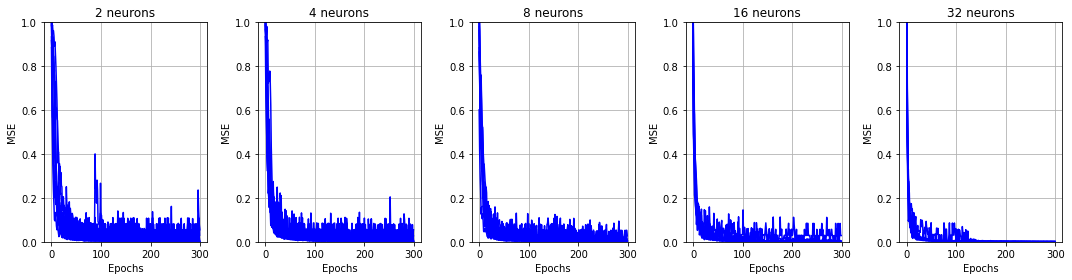

In [30]:
pl.figure(figsize=(15,4))
p_count = 0
for n in np.arange(MSE.shape[0]):
    pl.subplot(1, MSE.shape[0], n+1)
    for i in np.arange(MSE.shape[1]):
        pl.plot(MSE[n,i,:], c='b')
    pl.ylim(0,1)
    pl.xlabel('Epochs')
    pl.ylabel('MSE')
    pl.title(str(N_NEURONS[n]) + ' neurons')
    pl.grid()
pl.tight_layout()

### Exploring the number of hidden neurons

#### Parameters

In [31]:
EPOCHS = 250
K = 5
N_TESTS = 10
N_NEURONS = [2, 4, 6, 8, 10, 15, 20, 25, 30]

#### Training

In [32]:
MSE_train = np.zeros((len(N_NEURONS), EPOCHS, N_TESTS))
MSE_test = np.zeros((len(N_NEURONS), EPOCHS, N_TESTS))

for i_h, h in enumerate(N_NEURONS):                                     # looping the number of hidden neurons
    print('Testing', h, 'neurons...')
    nn = mlp.MLP([13,h,1], 'tanh')
    for i in np.arange(N_TESTS):                                        # looping the tests
        nn.init_weights()                                               # the network has to be reinitialized before each test
        temp1, temp2 = cv.k_fold_cross_validation_per_epoch(nn,         # notice that we do not use cv.k_fold_cross_validation
                                                            dataset,    # but cv.k_fold_cross_validation_per_epoch which
                                                            k=K,        # returns a value of error per each epoch
                                                            learning_rate=LEARNING_RATE,
                                                            momentum=MOMENTUM,
                                                            epochs=EPOCHS)
        # temp1 and temp2 are the training and test error. One value per epoch
        MSE_train[i_h, :, i] = temp1
        MSE_test[i_h, :, i] = temp2

Testing 2 neurons...
Testing 4 neurons...
Testing 6 neurons...
Testing 8 neurons...
Testing 10 neurons...
Testing 15 neurons...
Testing 20 neurons...
Testing 25 neurons...
Testing 30 neurons...


#### Results

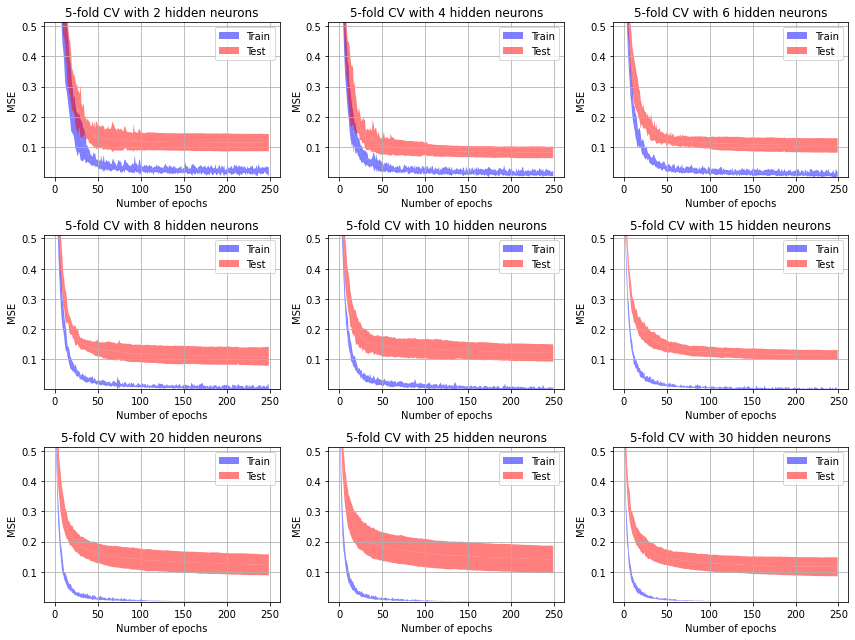

In [33]:
MSE_train_mean = np.mean(MSE_train, axis=2)
MSE_test_mean = np.mean(MSE_test, axis=2)
MSE_train_sd = np.std(MSE_train, axis=2)
MSE_test_sd = np.std(MSE_test, axis=2)

v_min = min(np.min(MSE_train_mean), np.min(MSE_test_mean))
v_max = max(np.max(MSE_train_mean), np.max(MSE_test_mean))

n_rows = int(np.ceil(len(N_NEURONS)/3.0))
pl.figure(figsize=(12,3*n_rows))
for i_n, n in enumerate(N_NEURONS):
    pl.subplot(n_rows, min(3, len(N_NEURONS)), i_n+1)
    pl.fill_between(np.arange(EPOCHS), MSE_train_mean[i_n,:], MSE_train_mean[i_n,:]+MSE_train_sd[i_n,:], facecolor='blue', alpha=0.5, label='Train')
    pl.fill_between(np.arange(EPOCHS), MSE_train_mean[i_n,:], MSE_train_mean[i_n,:]-MSE_train_sd[i_n,:], facecolor='blue', alpha=0.5)
    pl.fill_between(np.arange(EPOCHS), MSE_test_mean[i_n,:], MSE_test_mean[i_n,:]+MSE_test_sd[i_n,:], facecolor='red', alpha=0.5, label='Test')
    pl.fill_between(np.arange(EPOCHS), MSE_test_mean[i_n,:], MSE_test_mean[i_n,:]-MSE_test_sd[i_n,:], facecolor='red', alpha=0.5)
    pl.ylim(0.95*v_min,0.5*v_max)
    pl.ylabel('MSE')
    pl.xlabel('Number of epochs')
    pl.title(str(K)+'-fold CV with '+str(n)+' hidden neurons')
    pl.legend()
    pl.grid()
pl.tight_layout()

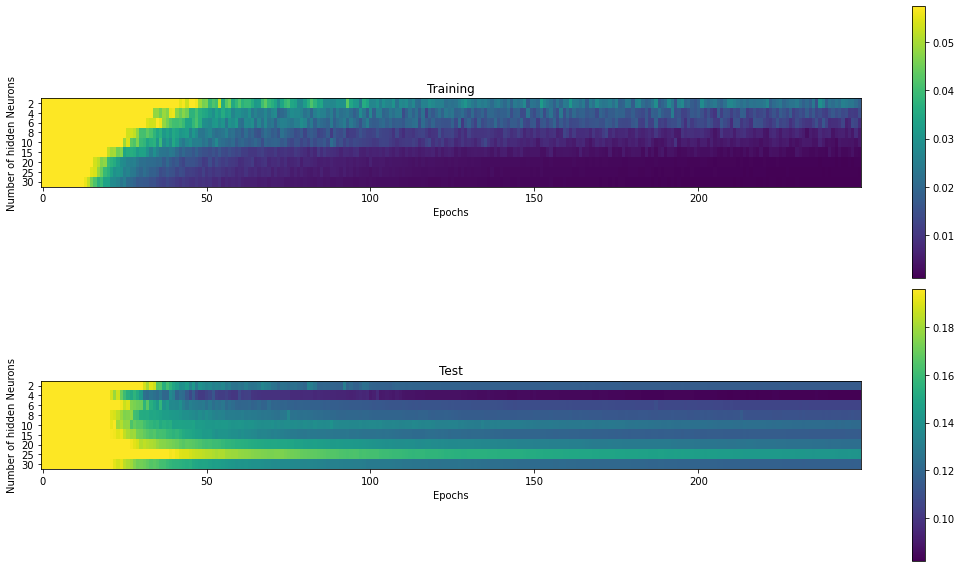

In [34]:
pl.figure(figsize=(15,8))
pl.subplot(2,1,1)
pl.imshow(MSE_train_mean, vmin=np.min(MSE_train_mean), vmax=np.percentile(MSE_train_mean, 90), aspect=3, interpolation='nearest')
pl.yticks(np.arange(len(N_NEURONS)), N_NEURONS)
pl.xlabel('Epochs')
pl.ylabel('Number of hidden Neurons')
pl.title('Training')
pl.colorbar()
pl.subplot(2,1,2)
pl.imshow(MSE_test_mean, vmin=np.min(MSE_test_mean), vmax=np.percentile(MSE_test_mean, 90), aspect=3, interpolation='nearest')
pl.yticks(np.arange(len(N_NEURONS)), N_NEURONS)
pl.xlabel('Epochs')
pl.ylabel('Number of hidden Neurons')
pl.title('Test')
pl.colorbar()
pl.tight_layout()

## The final model
An artificial neural network with 4 neurons in the hidden layer and 250 iterations of the backpropagation algorithm is enough to solve the problem.

In [35]:
nn = mlp.MLP([13,4,1], 'tanh')

In [38]:
MSE_train, MSE_test, conf_mat = cv.k_fold_cross_validation(nn,
                                                          dataset,
                                                          k=K,
                                                          learning_rate=LEARNING_RATE,
                                                          momentum=MOMENTUM,
                                                          epochs=250,
                                                          threshold=0.0)

In [39]:
print('MSE training: ', MSE_train)
print('MSE test: ', MSE_test)
print('Confusion matrix:')
print(conf_mat)

MSE training:  0.01074182720952276
MSE test:  0.07967828307281768
Confusion matrix:
[[70.  2.]
 [ 1. 71.]]
